# Подключение к хранилищу

In [1]:
import pyspark
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import numpy as np
import collections
import scipy
import scipy.stats

In [2]:

spark = pyspark.sql.SparkSession.builder.appName("startup_app") \
    .config("spark.mongodb.input.uri", "mongodb://mongo/startup_db.startups_coll") \
    .config('spark.jars', 'jars/mongo-spark-connector_2.11-2.4.2-assembly.jar') \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.11:2.4.2') \
    .getOrCreate()


In [3]:
df = spark.read.format('mongo').load()

In [4]:
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- angel_id: integer (nullable = true)
 |-- angel_url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- employees: string (nullable = true)
 |-- founders: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- link: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- bio: string (nullable = true)
 |-- location: string (nullable = true)
 |-- name: string (nullable = true)
 |-- raised: long (nullable = true)
 |-- website: string (nullable = true)



# Построение запросов

### Распределение полученных инвестиций

In [5]:
raised_df = df.where(F.col('raised') > 0).select('raised')

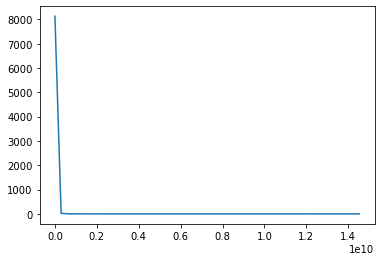

In [6]:
hist = raised_df.rdd.flatMap(lambda x: x).histogram(50)

plt.plot(hist[0][:-1], hist[1])

In [7]:
mean = raised_df.rdd.flatMap(lambda x: x).mean()
stdev = raised_df.rdd.flatMap(lambda x: x).stdev()
mean, stdev

(14687606.090074658, 222897795.56456104)

Видно, что величина инвестиций по различным компаниям распределена экспоненциально.
В среднем молодые компании получают $\$$11.000.000 инвестиций со стандартным отклонением в $\$$70.000.000.

## Диаграмма количества основателей

In [8]:
founders_counts_df = df.select(F.size('founders').alias('founders_count')).where(F.col('founders_count') > 0)
founders_counts = founders_counts_df.rdd.flatMap(lambda x: [x]).countByKey()

In [9]:
founders_counts_df.rdd.flatMap(lambda x: x).mean()

1.8886634542226706

([<matplotlib.patches.Wedge at 0x7f1d3fe84ad0>,
 [Text(0.3637501432409184, 1.0381164834893102, '1'),
  Text(-0.9243869287597677, -0.5962455919653281, '2'),
  Text(0.7379737264872573, -0.8157173401457829, '3'),
  Text(1.0437807824716718, -0.3471623224700871, '5'),
  Text(1.086614366379332, -0.17108249114986349, '4'),
  Text(1.0999363669991413, -0.011831675820889375, '6'),
  Text(1.0999986031893518, -0.0017529921491908208, '7'),
  Text(1.09999991265787, -0.0004383522315291321, '8')],
 [Text(0.19840916904050096, 0.5662453546305328, '39.3%'),
  Text(-0.5042110520507823, -0.32522486834472436, '39.7%'),
  Text(0.402531123538504, -0.4449367309886088, '15.5%'),
  Text(0.5693349722572755, -0.18936126680186566, '0.9%'),
  Text(0.5926987452978174, -0.09331772244538007, '4.4%'),
  Text(0.5999652910904406, -0.00645364135684875, '0.3%'),
  Text(0.5999992381032827, -0.0009561775359222658, '0.0%'),
  Text(0.5999999523588381, -0.00023910121719770839, '0.0%')])

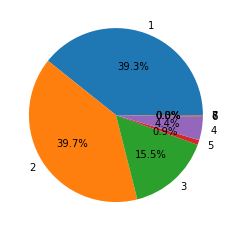

In [10]:
plt.pie([v for k,v in founders_counts.items()], labels=[k for k,v in founders_counts.items()], autopct='%1.1f%%')

Из диаграммы видно, что часто у стартапов всего 1-2 основателя (в среднем 1.88).

### Корреляция количества инвестиций с количеством основателей

In [11]:
from pyspark.mllib.stat import Statistics
corr_df = df.select('raised', F.size('founders').alias('founders_count')).where(F.col('raised') < 100_000_000)

raides_rdd = corr_df.select('raised').rdd.flatMap(lambda x: x)
founders_count_rdd = corr_df.select('founders_count').rdd.flatMap(lambda x: x)

corr_mat=Statistics.corr(raides_rdd, founders_count_rdd, method="pearson")

corr_mat

0.024711124374496525

Результирующа коррелаяиця составляет всего 0.024, что говорит о том, что количество денег, получаемых компанией в рамкех раунда инвестиций никак не коррелирует с количеством основателей.

# Выводы

Пример показывает, что представленная система позволяет усваивать, хранить и анализировать потенциально большие объемы данных.  
Данная система легко разворачивается, может горизонтально масштабироваться и представляет гибкие инструменты для аналитика данных.  
Информация, полученная на основе примененной аналитики, была использована в исследовательской работе по курсу многомерного анализа данных, что показывает практическую полезность проекта.  

